# Downloading the dataset

In [1]:
import kagglehub
import os

# Download dataset to kagglehub cache (it will use cached version if already downloaded)
print("Downloading/loading dataset from kagglehub cache...")
path = kagglehub.dataset_download("co1d7era/mixedtype-wafer-defect-datasets/versions/3")

print(f"Dataset path: {path}")
print(f"Dataset exists: {os.path.exists(path)}")

# List files in the dataset directory
if os.path.exists(path):
    files = os.listdir(path)
    print(f"\nFiles in dataset: {files}")

Downloading/loading dataset from kagglehub cache...
Dataset path: C:\Users\akash\.cache\kagglehub\datasets\co1d7era\mixedtype-wafer-defect-datasets\versions\3
Dataset exists: True

Files in dataset: ['E.pdf', 'Wafer_Map_Datasets.npz']


# Loading the data from the folder

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data directly from kagglehub cache path
data = np.load(os.path.join(path, "Wafer_Map_Datasets.npz"))
print(data['arr_0'].shape)

(38015, 52, 52)


In [3]:
print(data['arr_0'][25][25][25])

1


# Data Exploration

In [4]:
# Check what arrays are in the npz file
print("Available arrays:", data.files)
print()

# Explore each array
for array_name in data.files:
    arr = data[array_name]
    print(f"{array_name}:")
    print(f"  Shape: {arr.shape}")
    print(f"  Dtype: {arr.dtype}")
    print(f"  Sample values: {arr[:3] if len(arr.shape) == 1 else 'N/A'}")
    print()

Available arrays: ['arr_0', 'arr_1']

arr_0:
  Shape: (38015, 52, 52)
  Dtype: int32
  Sample values: N/A

arr_1:
  Shape: (38015, 8)
  Dtype: int32
  Sample values: N/A

arr_0:
  Shape: (38015, 52, 52)
  Dtype: int32
  Sample values: N/A

arr_1:
  Shape: (38015, 8)
  Dtype: int32
  Sample values: N/A



In [5]:
# Assuming arr_0 contains wafer maps and there's a label array
# Let's check if there are labels and identify unique classes
if len(data.files) > 1:
    # Try to find labels (commonly named arr_1, labels, etc.)
    for name in data.files:
        arr = data[name]
        if len(arr.shape) == 1 or (len(arr.shape) == 2 and arr.shape[1] == 1):
            print(f"Potential label array: {name}")
            print(f"Unique classes: {np.unique(arr)}")
            print(f"Class distribution:")
            unique, counts = np.unique(arr, return_counts=True)
            for cls, cnt in zip(unique, counts):
                print(f"  Class {cls}: {cnt} samples")
            print()

Wafer maps shape: (38015, 52, 52)
Total samples: 38015


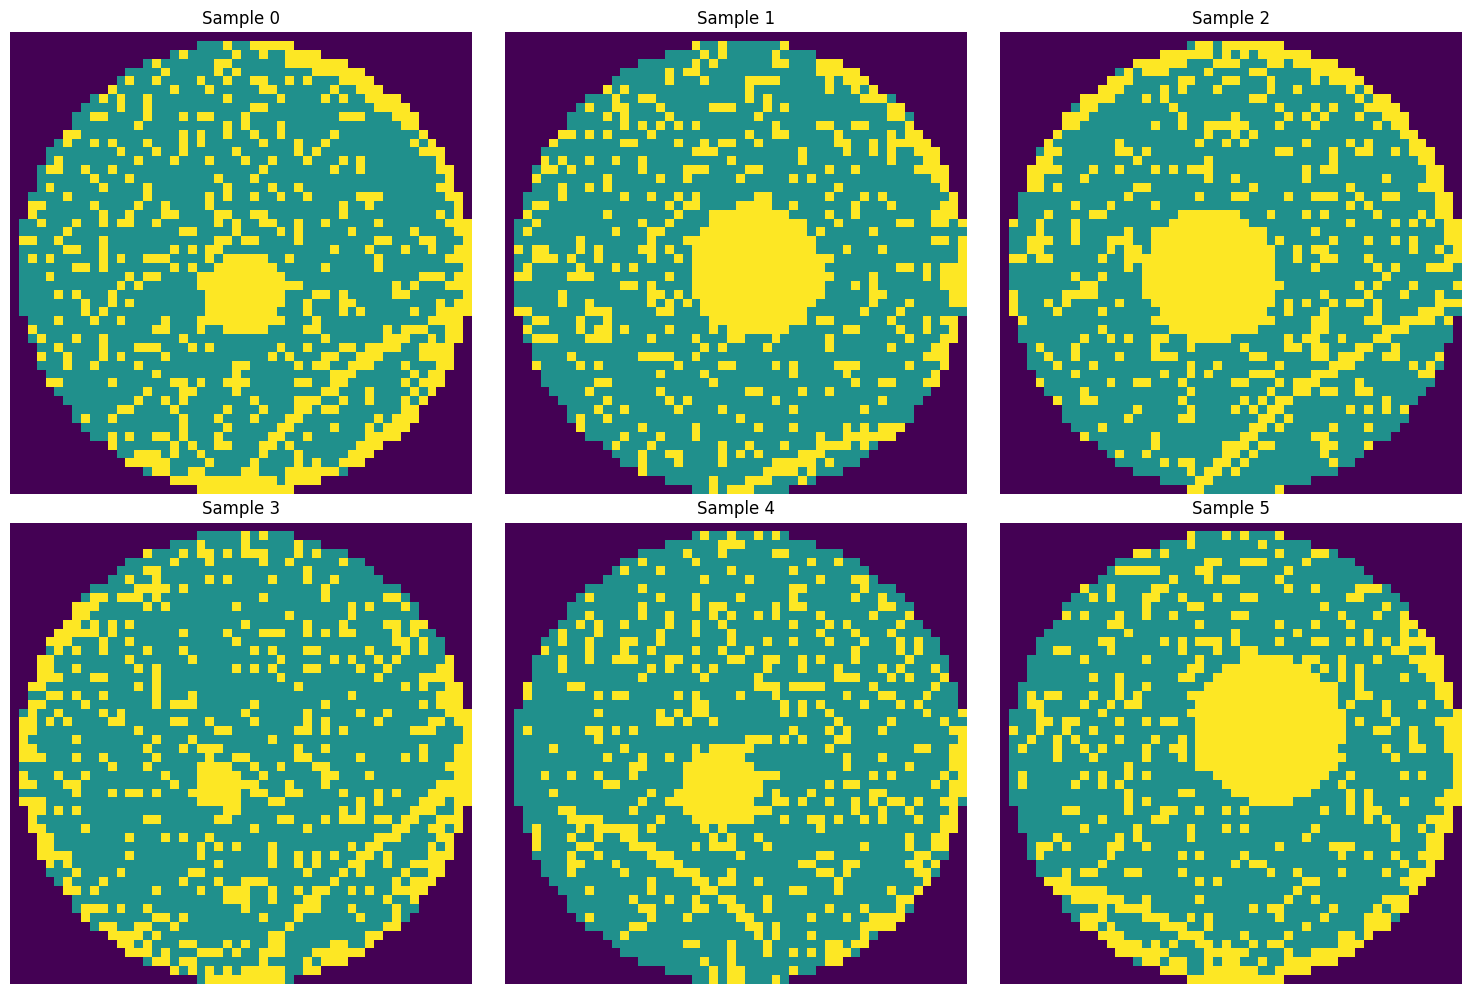

In [6]:
# Visualize sample wafer maps from different classes
wafer_maps = data['arr_0']
print(f"Wafer maps shape: {wafer_maps.shape}")
print(f"Total samples: {wafer_maps.shape[0]}")

# Display a few sample wafer maps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    if i < wafer_maps.shape[0]:
        axes[i].imshow(wafer_maps[i], cmap='viridis')
        axes[i].set_title(f'Sample {i}')
        axes[i].axis('off')
        
plt.tight_layout()
plt.show()

# Data Preprocessing

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load data
X = data['arr_0']  # Wafer maps
y = data['arr_1'] if 'arr_1' in data.files else None  # Labels

print(f"Initial X shape: {X.shape}")
if y is not None:
    print(f"Initial y shape: {y.shape}")

# If labels exist, handle them correctly
if y is not None:
    # The labels are 8-column binary patterns representing 38 unique defect combinations
    # Convert each unique pattern to a class index
    
    # Find unique patterns and create a mapping
    unique_patterns, y_indices = np.unique(y, axis=0, return_inverse=True)
    
    num_classes = len(unique_patterns)
    print(f"\nFound {num_classes} unique defect patterns (classes)")
    print(f"Converting multi-label patterns to class indices...")
    
    # y_indices now contains the class index for each sample
    y = y_indices
    
    print(f"Number of classes: {num_classes}")
    print(f"Class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for cls, cnt in zip(unique[:10], counts[:10]):  # Show first 10
        print(f"  Class {cls}: {cnt} samples")
    if len(unique) > 10:
        print(f"  ... ({len(unique) - 10} more classes)")
else:
    print("No labels found in the dataset")
    
# Normalize pixel values to [0, 1]
X = X.astype('float32')
X_min, X_max = X.min(), X.max()
X = (X - X_min) / (X_max - X_min) if X_max > X_min else X

# Add channel dimension if needed (for CNN)
if len(X.shape) == 3:
    X = np.expand_dims(X, axis=1)  # PyTorch uses (N, C, H, W) format
    
print(f"\nFinal input shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Channels: {X.shape[1]}")
print(f"Image dimensions: {X.shape[2]} x {X.shape[3]}")
if y is not None:
    print(f"Labels shape: {y.shape}")

Initial X shape: (38015, 52, 52)
Initial y shape: (38015, 8)

Found 38 unique defect patterns (classes)
Converting multi-label patterns to class indices...
Number of classes: 38
Class distribution:
  Class 0: 1000 samples
  Class 1: 866 samples
  Class 2: 1000 samples
  Class 3: 149 samples
  Class 4: 1000 samples
  Class 5: 1000 samples
  Class 6: 1000 samples
  Class 7: 1000 samples
  Class 8: 1000 samples
  Class 9: 1000 samples
  ... (28 more classes)

Final input shape: (38015, 1, 52, 52)
Number of samples: 38015
Channels: 1
Image dimensions: 52 x 52
Labels shape: (38015,)

Final input shape: (38015, 1, 52, 52)
Number of samples: 38015
Channels: 1
Image dimensions: 52 x 52
Labels shape: (38015,)


In [22]:
# Verify the shapes match before splitting
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape if y is not None else 'None'}")
if y is not None:
    print(f"Shapes match: {X.shape[0] == len(y)}")

X shape: (38015, 1, 52, 52)
y shape: (38015,)
Shapes match: True


In [23]:
# Let's examine all 8 columns of the label array to find the actual class labels
print("Examining all columns of arr_1:")
for col in range(data['arr_1'].shape[1]):
    unique_vals = np.unique(data['arr_1'][:, col])
    print(f"Column {col}: {len(unique_vals)} unique values - {unique_vals[:10] if len(unique_vals) <= 10 else f'{unique_vals[:5]}...{unique_vals[-5:]}'}")
    
# Check if any column has more classes
print("\nLet's check which column might be the main class label:")
for col in range(data['arr_1'].shape[1]):
    n_unique = len(np.unique(data['arr_1'][:, col]))
    print(f"Column {col}: {n_unique} classes")

Examining all columns of arr_1:
Column 0: 2 unique values - [0 1]
Column 1: 2 unique values - [0 1]
Column 2: 2 unique values - [0 1]
Column 3: 2 unique values - [0 1]
Column 4: 2 unique values - [0 1]
Column 5: 2 unique values - [0 1]
Column 6: 2 unique values - [0 1]
Column 7: 2 unique values - [0 1]

Let's check which column might be the main class label:
Column 0: 2 classes
Column 1: 2 classes
Column 2: 2 classes
Column 3: 2 classes
Column 4: 2 classes
Column 5: 2 classes
Column 6: 2 classes
Column 7: 2 classes


In [24]:
# Check if this is one-hot encoding or multi-label
# If one-hot, each row should have exactly one '1'
# Let's check the sum of each row and unique patterns

row_sums = data['arr_1'].sum(axis=1)
print(f"Row sums - Min: {row_sums.min()}, Max: {row_sums.max()}, Unique sums: {np.unique(row_sums)}")

# Check unique combinations (patterns)
unique_patterns = np.unique(data['arr_1'], axis=0)
print(f"\nNumber of unique label patterns: {len(unique_patterns)}")
print("\nFirst 10 unique patterns:")
for i, pattern in enumerate(unique_patterns[:10]):
    count = np.sum(np.all(data['arr_1'] == pattern, axis=1))
    print(f"Pattern {i}: {pattern} - Count: {count}")
    
if len(unique_patterns) <= 20:
    print("\nAll unique patterns:")
    for i, pattern in enumerate(unique_patterns):
        count = np.sum(np.all(data['arr_1'] == pattern, axis=1))
        print(f"Pattern {i}: {pattern} - Count: {count}")

Row sums - Min: 0, Max: 4, Unique sums: [0 1 2 3 4]

Number of unique label patterns: 38

First 10 unique patterns:
Pattern 0: [0 0 0 0 0 0 0 0] - Count: 1000
Pattern 1: [0 0 0 0 0 0 0 1] - Count: 866
Pattern 2: [0 0 0 0 0 0 1 0] - Count: 1000
Pattern 3: [0 0 0 0 0 1 0 0] - Count: 149
Pattern 4: [0 0 0 0 1 0 0 0] - Count: 1000
Pattern 5: [0 0 0 0 1 0 1 0] - Count: 1000
Pattern 6: [0 0 0 1 0 0 0 0] - Count: 1000
Pattern 7: [0 0 0 1 0 0 1 0] - Count: 1000
Pattern 8: [0 0 0 1 1 0 0 0] - Count: 1000
Pattern 9: [0 0 0 1 1 0 1 0] - Count: 1000


In [25]:
# Split data into train, validation, and test sets
if y is not None:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    
    y_train_tensor = torch.LongTensor(y_train)
    y_val_tensor = torch.LongTensor(y_val)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create DataLoaders
    batch_size = 32
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")
else:
    print("Cannot split data without labels")

Training set: 26610 samples
Validation set: 5702 samples
Test set: 5703 samples
Number of batches - Train: 832, Val: 179, Test: 179


# Build CNN Model

In [26]:
# Check GPU availability
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU device:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())
else:
    print("No GPU detected. Will use CPU.")

CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce RTX 4060 Laptop GPU
Number of GPUs: 1


In [27]:
# Check PyTorch version and build
print(f"PyTorch version: {torch.__version__}")
print(f"Built with CUDA: {torch.version.cuda if torch.version.cuda else 'No (CPU-only version)'}")

# Check if you have an NVIDIA GPU using cupy (if installed)
try:
    import cupy as cp
    print("\nCuPy detected - GPU might be available but PyTorch needs reinstallation")
    print(f"CuPy CUDA version: {cp.cuda.runtime.runtimeGetVersion()}")
except ImportError:
    print("\nCuPy not installed or no GPU detected")

PyTorch version: 2.5.1+cu121
Built with CUDA: 12.1

CuPy detected - GPU might be available but PyTorch needs reinstallation
CuPy CUDA version: 12090


In [28]:
# Define CNN Model
class WaferCNN(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super(WaferCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
        # Calculate the size after convolutions and pooling
        # This will be adjusted based on actual input size
        self.fc1 = None
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Conv Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Initialize fc1 on first forward pass
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 256).to(x.device)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
if y is not None:
    model = WaferCNN(num_classes=num_classes, input_channels=X.shape[1])
    model = model.to(device)
    
    # Print model summary
    print("\nModel Architecture:")
    print(model)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda

Model Architecture:
WaferCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=38, bias=True)
)

Total parameters: 130,918
Trainable parameters: 130,918


# Train the Model

In [29]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

print("Training functions defined successfully")

Training functions defined successfully


In [30]:
# Training loop
num_epochs = 30
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0.0
best_model_state = None

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 60)

print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")

# Load best model
model.load_state_dict(best_model_state)

Starting training...
------------------------------------------------------------
Epoch [1/30]
  Train Loss: 1.9034, Train Acc: 0.3909
  Val Loss: 0.8161, Val Acc: 0.7262
  LR: 0.001000
------------------------------------------------------------
Epoch [1/30]
  Train Loss: 1.9034, Train Acc: 0.3909
  Val Loss: 0.8161, Val Acc: 0.7262
  LR: 0.001000
------------------------------------------------------------
Epoch [5/30]
  Train Loss: 0.4924, Train Acc: 0.8309
  Val Loss: 0.2605, Val Acc: 0.9160
  LR: 0.001000
------------------------------------------------------------
Epoch [5/30]
  Train Loss: 0.4924, Train Acc: 0.8309
  Val Loss: 0.2605, Val Acc: 0.9160
  LR: 0.001000
------------------------------------------------------------
Epoch [10/30]
  Train Loss: 0.3348, Train Acc: 0.8897
  Val Loss: 0.1795, Val Acc: 0.9427
  LR: 0.001000
------------------------------------------------------------
Epoch [10/30]
  Train Loss: 0.3348, Train Acc: 0.8897
  Val Loss: 0.1795, Val Acc: 0.9427
  

<All keys matched successfully>

# Visualize Training Progress

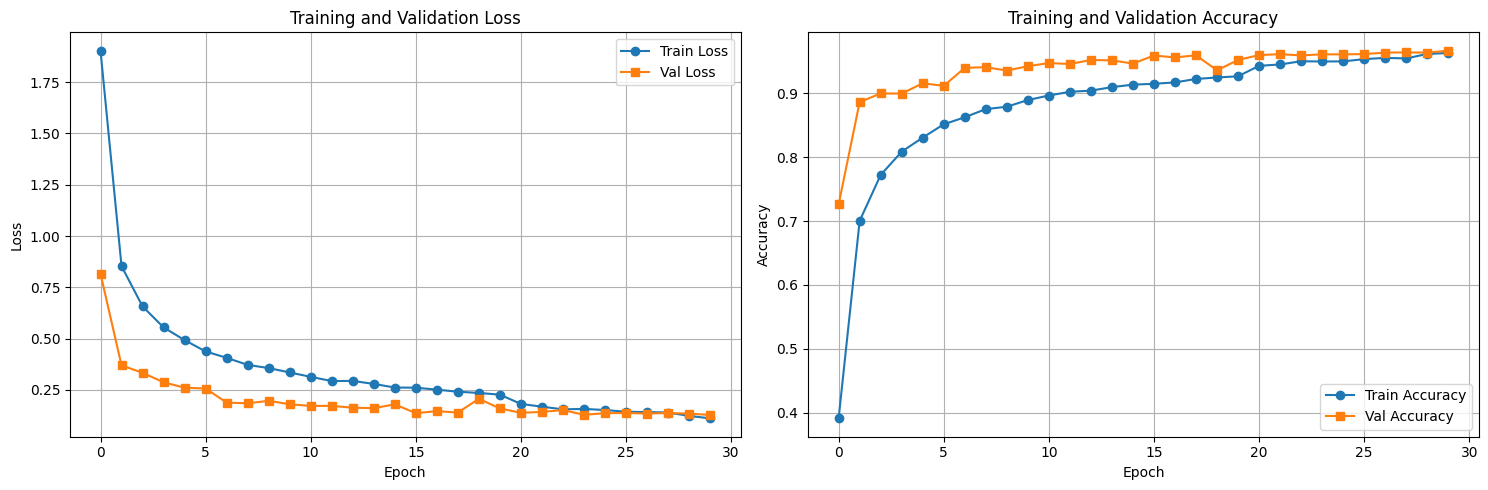

In [31]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', marker='o')
ax2.plot(val_accs, label='Val Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on Test Set

In [32]:
# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Get predictions for confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Test Loss: 0.1008
Test Accuracy: 0.9726


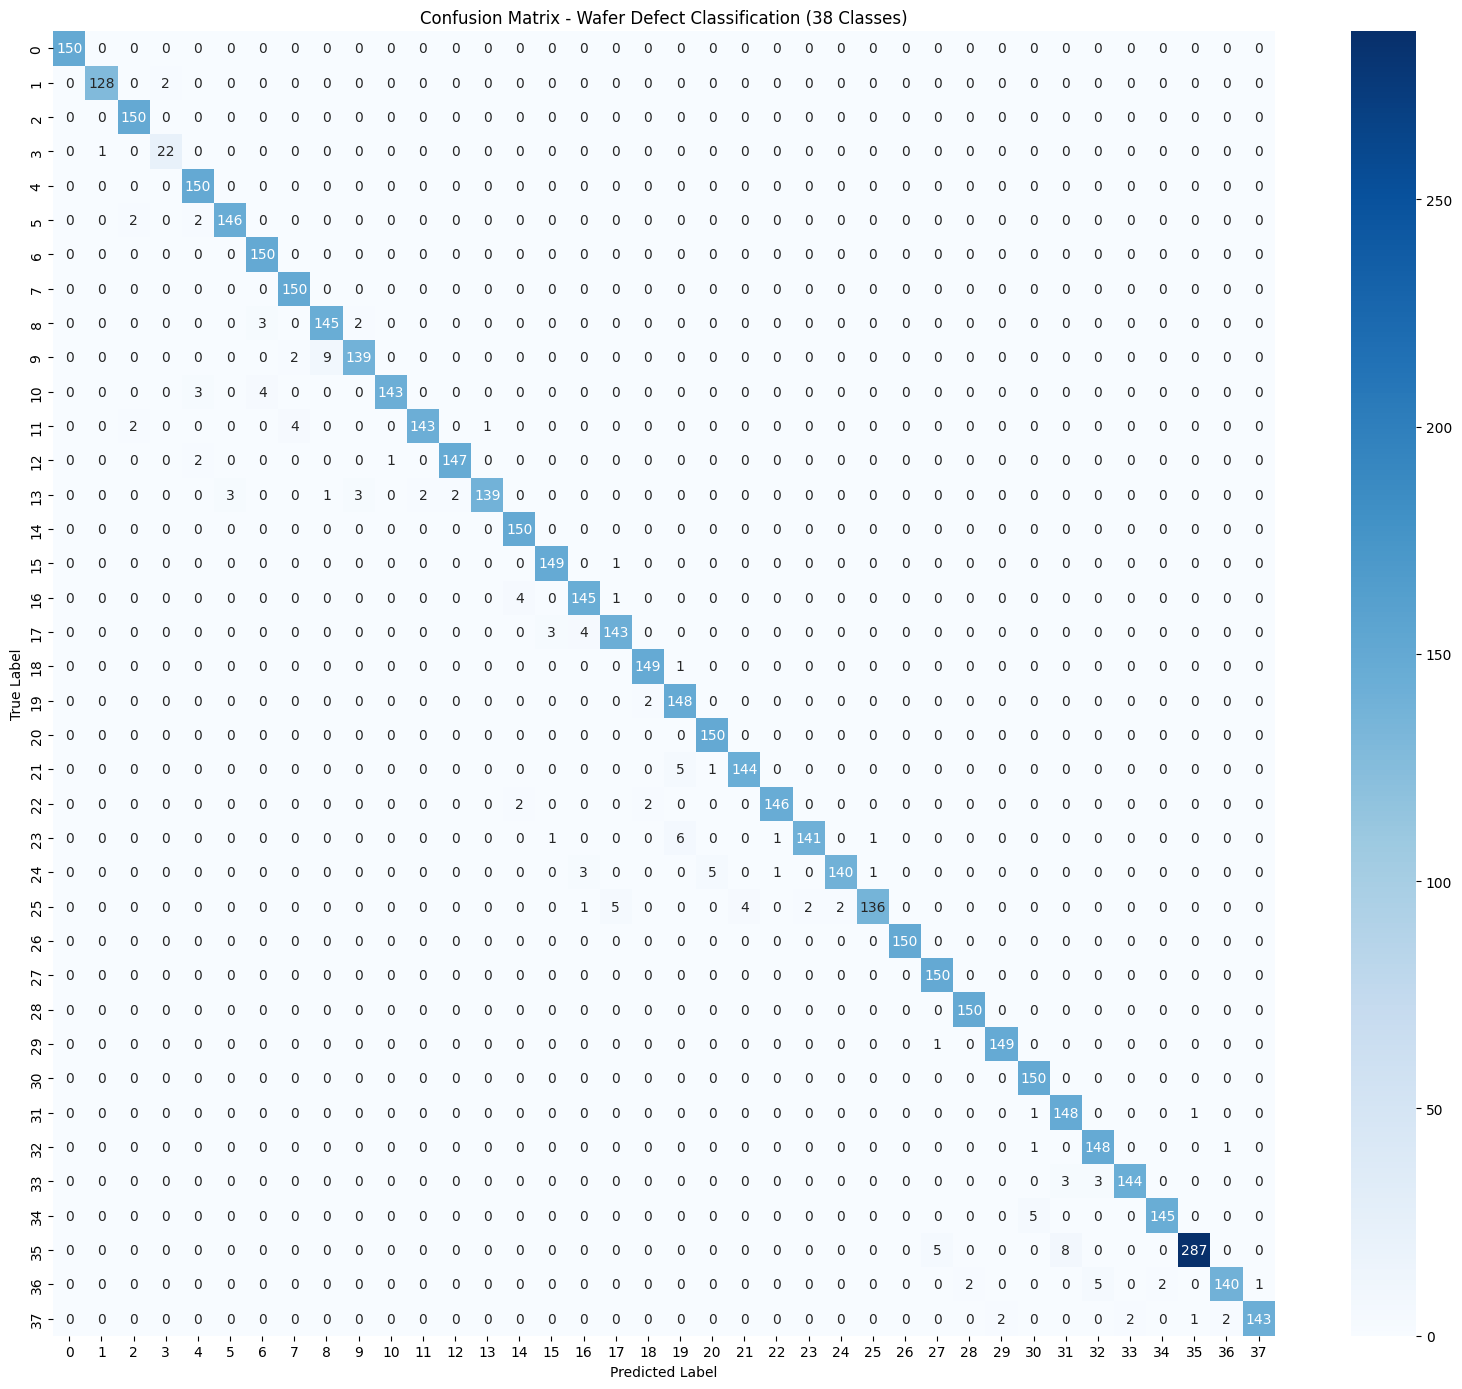


Classification Report:
              precision    recall  f1-score   support

     Class_0       1.00      1.00      1.00       150
     Class_1       0.99      0.98      0.99       130
     Class_2       0.97      1.00      0.99       150
     Class_3       0.92      0.96      0.94        23
     Class_4       0.96      1.00      0.98       150
     Class_5       0.98      0.97      0.98       150
     Class_6       0.96      1.00      0.98       150
     Class_7       0.96      1.00      0.98       150
     Class_8       0.94      0.97      0.95       150
     Class_9       0.97      0.93      0.95       150
    Class_10       0.99      0.95      0.97       150
    Class_11       0.99      0.95      0.97       150
    Class_12       0.99      0.98      0.98       150
    Class_13       0.99      0.93      0.96       150
    Class_14       0.96      1.00      0.98       150
    Class_15       0.97      0.99      0.98       150
    Class_16       0.95      0.97      0.96       150
   

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Wafer Defect Classification (38 Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[f'Class_{i}' for i in range(num_classes)]))